# Install Dependencies

In [53]:
!pip install gensim
!pip install pyLDAvis

In [54]:
from sklearn.cluster import KMeans 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt


# Enable logging for gensim - optional
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [55]:
FILENAME = "../data/processed_data/clear_text.txt"
UNREAD_FILENAME = "../data/processed_data/test_folder/unreadable.txt"
STOPWORDS_FILENAME = "../data/stopwords.txt"

In [56]:
with open(FILENAME, "r") as file:
    voc = [i.split() for i in file.read().strip().split("\n")]
    
with open(UNREAD_FILENAME, "r") as file:
    unread = file.read()

with open(STOPWORDS_FILENAME, "r") as file:
    stopwords = file.read().strip().split()

---

# Scikit-Learn Realization

In [57]:
with open(FILENAME, "r") as file:
    vocabulary = file.read().split("\n")

cv = CountVectorizer()
dataset = cv.fit_transform(vocabulary)
dataset

<645x35353 sparse matrix of type '<class 'numpy.int64'>'
	with 280763 stored elements in Compressed Sparse Row format>

In [58]:
lda = LDA(
    n_components = 10,
    max_iter=30,
    n_jobs=-1,
    learning_method='batch',
    verbose=1
)
lda.fit(dataset)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(max_iter=30, n_jobs=-1, verbose=1)

In [59]:
class TopicModeler(object):
    '''
    Inteface object for CountVectorizer + LDA simple
    usage.
    '''
    def __init__(self, count_vect, lda):
        '''
        Args:
             count_vect - CountVectorizer object from sklearn.
             lda - LDA object from sklearn.
        '''
        self.lda = lda
        self.count_vect = count_vect
        self.count_vect.input = 'content'

    def __call__(self, text):
        '''
        Gives topics distribution for a given text
        Args:
             text - raw text via python string.
        returns: numpy array - topics distribution for a given text.
        '''
        vectorized = self.count_vect.transform([text])
        lda_topics = self.lda.transform(vectorized)
        return lda_topics
    
    def get_keywords(self, text, n_topics=3, n_keywords=5):
        '''
        For a given text gives n top keywords for each of m top texts topics.
        Args:
             text - raw text via python string.
             n_topics - int how many top topics to use.
             n_keywords - how many top words of each topic to return.
        returns:
                list - of m*n keywords for a given text.
        '''
        lda_topics = self(text)
        lda_topics = np.squeeze(lda_topics, axis=0)
        n_topics_indices = lda_topics.argsort()[-n_topics:][::-1]

        top_topics_words_dists = []
        for i in n_topics_indices:
            top_topics_words_dists.append(self.lda.components_[i])

        shape=(n_keywords*n_topics, self.lda.components_.shape[1])
        keywords = np.zeros(shape=shape)
        for i,topic in enumerate(top_topics_words_dists):
            n_keywords_indices = topic.argsort()[-n_keywords:][::-1]
            for k,j in enumerate(n_keywords_indices):
                keywords[i * n_keywords + k, j] = 1
        keywords = self.count_vect.inverse_transform(keywords)
        keywords = [keyword[0] for keyword in keywords]
        return keywords  

In [60]:
tm = TopicModeler(cv, lda)
key_words = tm.get_keywords(" ".join(vocabulary), n_topics=1, n_keywords=10)
print(key_words)

['скважина', 'пласт', 'месторождение', 'нефть', 'жидкость', 'давление', 'бурение', 'разработка', 'колонна', 'раствор']


In [61]:
term_doc_matrix = cv.transform(vocabulary)
embeddings = lda.transform(term_doc_matrix)

kmeans = KMeans(n_clusters=30)
clust_labels = kmeans.fit_predict(embeddings)
clust_centers = kmeans.cluster_centers_

embeddings_to_tsne = np.concatenate((embeddings,clust_centers), axis=0)

tSNE =  TSNE(n_components=2, perplexity=15)
tsne_embeddings = tSNE.fit_transform(embeddings_to_tsne)
tsne_embeddings, centroids_embeddings = np.split(tsne_embeddings, [len(clust_labels)], axis=0)

In [62]:
print(tsne_embeddings.shape,centroids_embeddings.shape)

(645, 2) (30, 2)


In [63]:
clust_indices = np.unique(clust_labels)

clusters = {clust_ind : [] for clust_ind in clust_indices}
for emb, label in zip(tsne_embeddings, clust_labels):
    clusters[label].append(emb)

for key in clusters.keys():
    clusters[key] = np.array(clusters[key])
colors = cm.rainbow(np.linspace(0, 1, len(clust_indices)))

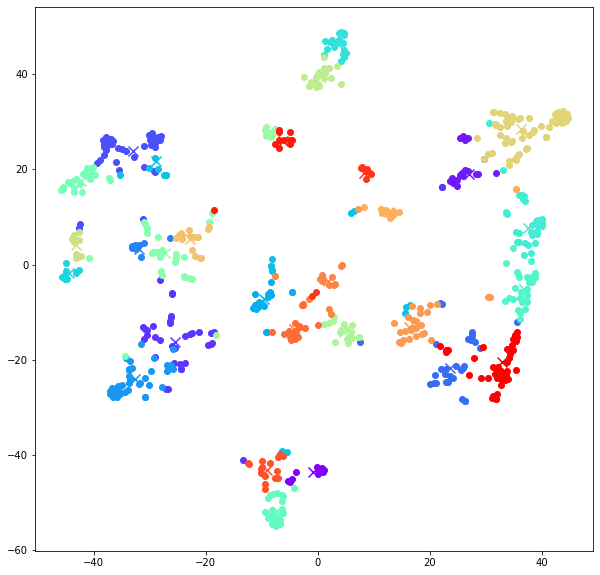

In [64]:
plt.figure(figsize=(10,10))
for ind, color in zip(clust_indices, colors):
    x = clusters[ind][:,0]
    y = clusters[ind][:,1]
    plt.scatter(x, y, color=color)
    
    centroid = centroids_embeddings[ind]
    plt.scatter(centroid[0],centroid[1], color=color, marker='x', s=100)

---

# Gensim Realization

In [65]:
id2word = corpora.Dictionary(voc)
texts = voc
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=10, 
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [ ]:
lda_model.print_topics()

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis